# Global Monsoon pattern

In this tutorial we show how the Global Monsoon index as it is defined by Wang et al. 2008 is derived.


In [1]:
import numpy as np
import geoutils.plotting.plots as gplt
import geoutils.geodata.base_dataset as bds
import geoutils.utils.time_utils as tu
import geoutils.tsa.time_series_analysis as tsa
import geoutils.tsa.propagation as prop
import geoutils.tsa.pca.eof as eof
import geoutils.tsa.pca.multivariate_pca as mvpca
import geoutils.utils.general_utils as gut
from importlib import reload

plot_dir = "/home/strnad/data/plots/tutorials/global_monsoon/"
data_dir = "/home/strnad/data/"

In [5]:
# Load the dataset
reload(bds)
grid_step = 1
dataset_file = data_dir + \
    f"climate_data/{grid_step}/mswep_pr_{grid_step}_ds.nc"

lon_range_cut = [-180, 180]
lat_range_cut = [-50, 50]

ds_pr = bds.BaseDataset(data_nc=dataset_file,
                        can=True,
                        an_types=['dayofyear', 'month', 'JJAS'],
                        lon_range=lon_range_cut,
                        lat_range=lat_range_cut,
                        verbose=False,
                        )


Open files: ['/home/strnad/data/climate_data/1/mswep_pr_1_ds.nc']
Created dayofyearly anomalies!
Rename pr to pr_an_dayofyear!
Created monthly anomalies!
Rename pr to pr_an_month!


/home/strnad/anaconda3/envs/climnet/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
/home/strnad/anaconda3/envs/climnet/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]


Created JJASly anomalies!
Rename pr to pr_an_JJAS!
Attention! All data is read into memory!


Now we perform an EOF analysis of the precipitation field


Univariate PCA var with dataarray
Explained variance: 0.591462254524231


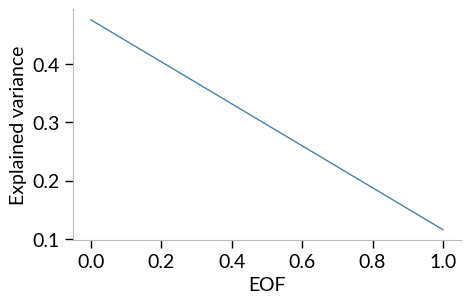

In [114]:
reload(tu)
reload(mvpca)
n_components = 2
input_data = ds_pr.ds['pr']
# input_data is the 12 month climatology
# This create a time series of the mean precipitation in the region per month/day
timemean = 'dayofyear'
yearly_mean_pr = tu.compute_timemean(input_data,
                                     timemean=timemean,
                                     groupby=True,
                                     reset_time=True,  # important for EOF labeling
                                     )

reload(eof)
reload(mvpca)
sppca = mvpca.MultivariatePCA(yearly_mean_pr, n_components=n_components)
pcs = sppca.get_principal_components()
gut.myprint(f"Explained variance: {np.sum(sppca.explained_variance())}")

reload(gplt)
im = gplt.plot_xy(y_arr=sppca.explained_variance(),
                  xlabel='EOF', ylabel='Explained variance',
                  ylog=False, figsize=(5, 3))

In [116]:
eofs = sppca.get_eofs()
reofs = sppca.eofs_real_space()
reofs.sel(eof=0)

[[1. 0.]
 [0. 1.]]


<xarray.DataArray 'pr' (lat: 100, lon: 360)>
array([[2.15774111, 2.27479665, 2.3992721 , ..., 2.11767814, 2.09980664,
        2.15013941],
       [2.09319989, 2.07342643, 2.25754588, ..., 2.15794679, 2.14490832,
        2.09854809],
       [2.00903165, 2.02915778, 2.176018  , ..., 2.03531103, 1.9959357 ,
        2.03065954],
       ...,
       [4.01673469, 3.97739212, 3.98001139, ..., 4.12865338, 4.07865509,
        4.01178284],
       [3.90860076, 3.83932175, 3.7640913 , ..., 3.98995602, 3.92699507,
        3.90505683],
       [3.73294693, 3.65825357, 3.63928889, ..., 3.80612397, 3.73222378,
        3.7221881 ]])
Coordinates:
    metpy_crs  object Projection: latitude_longitude
    eof        int64 0
  * lat        (lat) float64 -49.75 -48.74 -47.74 -46.73 ... 47.74 48.74 49.75
  * lon        (lon) float64 -179.9 -178.9 -177.9 -176.9 ... 177.9 178.9 179.9

In [138]:
import geoutils.utils.statistic_utils as stut

sing_vals =sppca.pca.singular_values_
expl_var = sppca.explained_variance()

In [143]:
sppca.pca.get_covariance()[0]

array([1330.7092, 1595.1921, 1423.199 , ..., 2334.2097, 1896.8939,
       1669.6879], dtype=float32)

Now plot the EOF and their corresponding PC time series.


[[1. 0.]
 [0. 1.]]


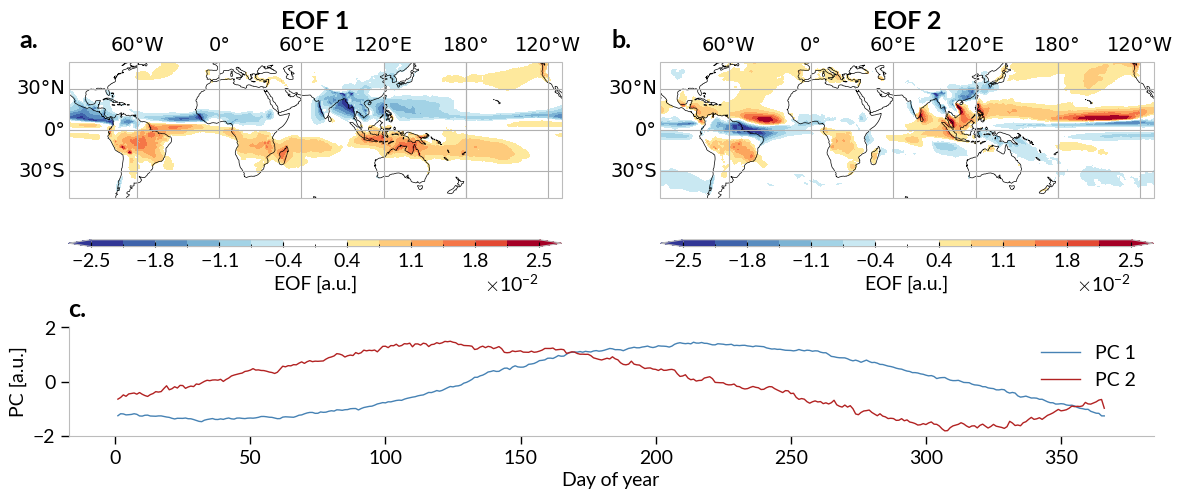

In [146]:
# EOF maps
reload(gut)
nrows = 1
eofs = sppca.get_eofs()
reofs = sppca.eofs_real_space()
ncols = n_components
im = gplt.create_multi_plot(nrows=2, ncols=ncols,
                            hspace=0.2,
                            wspace=0.2,
                            full_length_row=True,
                            figsize=(14, 6),
                            ratios_h=[2,.7],
                            proj_arr=['PlateCarree',
                                      'PlateCarree', None],
                            end_idx=3,
                            central_longitude=70,
                            )
for i in range(sppca.n_components):
    comp = eofs.isel(eof=i)
    im_eof = gplt.plot_map(comp,
                           ax=im['ax'][i],
                           vmin=-0.025, vmax=0.025,
                           cmap='RdYlBu_r',
                           levels=14,
                           title=f'EOF {i+1}',
                           centercolor='white',
                           label='EOF [a.u.]',
                           )


# Now we plot the PCs
pcs = sppca.get_principal_components()
for i in range(sppca.n_components):
    gplt.plot_xy(
        ax=im['ax'][2],
        x_arr=[pcs['time']],
        y_arr=[-1*pcs.sel(eof=i)],
        xlabel='Day of year',
        ylabel=f'PC [a.u.]',
        figsize=(6, 3),
        color=gplt.colors[i],
        label_arr=[f'PC {i+1}'],
        loc='upper right',
        ylim=[-2, 2],
        set_axis=True,
    )
savepath = plot_dir +\
    f"/gm_eofs.png"
gplt.save_fig(savepath, fig=im['fig'])

## Definition of global monsoon regions

Global monsoon regions are defined by regions where the summer - winter precipitation exceeds 2mm/day and about 60% of the annual rainfall is in JJAS


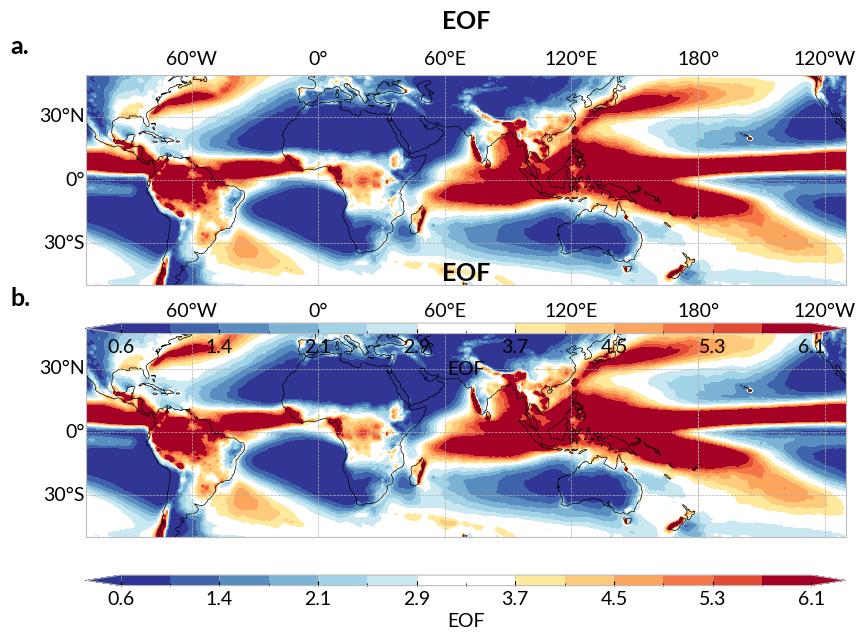

In [94]:
im = gplt.create_multi_plot(nrows=2, ncols=1,
                            hspace=0.4,
                            wspace=0.2,
                            full_length_row=True,
                            figsize=(14, 6),
                            central_longitude=70,
                            projection='PlateCarree',
                            )
for i, comp in enumerate([reofs.sel(eof=0), reofs.sel(eof=1)]):
    im_eof = gplt.plot_map(comp,
                           ax=im['ax'][i],
                        #    vmin=-5, vmax=15,
                           cmap='RdYlBu_r',
                           levels=14,
                           title=f'EOF',
                           centercolor='white',
                           label='EOF',
                           )

In [69]:
sppca.inverse_transform(np.array([[1,0], [0, 1], [1, 1]]))

<xarray.DataArray 'pr' (time: 3, lat: 100, lon: 360)>
array([[[2.15774758, 2.27479652, 2.39927204, ..., 2.11767811,
         2.09980664, 2.1501393 ],
        [2.0931998 , 2.07342637, 2.25754573, ..., 2.1579467 ,
         2.14490824, 2.09854809],
        [2.00903151, 2.02915769, 2.17601788, ..., 2.0353109 ,
         1.99593555, 2.03065938],
        ...,
        [4.0167354 , 3.97739279, 3.98001201, ..., 4.12865415,
         4.07865578, 4.01178357],
        [3.90860143, 3.83932246, 3.76409192, ..., 3.98995671,
         3.92699578, 3.90505762],
        [3.73294768, 3.65825427, 3.63928968, ..., 3.80612469,
         3.73222452, 3.72218888]],

       [[1.99532   , 2.03371029, 2.13371515, ..., 2.03543647,
         1.99517194, 1.98201964],
        [1.98613371, 1.94393274, 2.04655558, ..., 1.99931628,
         1.98955713, 1.97117287],
        [1.90472869, 1.89363365, 1.97097519, ..., 1.862739  ,
         1.85906091, 1.88957111],
...
        [4.44328552, 4.37948757, 4.41071922, ..., 4.51171398,
         4.48907512, 4.4399392 ],
        [4.30655426, 4.2528221 , 4.21234059, ..., 4.34870327,
         4.32502151, 4.30318087],
        [4.12949044, 4.06165922, 4.07206583, ..., 4.18022686,
         4.14245707, 4.13139904]],

       [[2.12187266, 2.20606048, 2.28375418, ..., 2.12467959,
         2.082546  , 2.10585136],
        [2.05281945, 2.03656837, 2.17034277, ..., 2.11011522,
         2.07840911, 2.04759119],
        [1.90177871, 1.93611429, 2.04664794, ..., 1.91057808,
         1.86078241, 1.91271839],
        ...,
        [4.65248552, 4.57671255, 4.57870783, ..., 4.80894867,
         4.7419126 , 4.64254799],
        [4.55226526, 4.46958788, 4.37295361, ..., 4.672703  ,
         4.58616045, 4.54425944],
        [4.3732821 , 4.27638412, 4.26313478, ..., 4.48612505,
         4.39889252, 4.36067395]]])
Coordinates:
    metpy_crs  object Projection: latitude_longitude
  * time       (time) int64 1 1 1
  * lat        (lat) float64 -49.75 -48.74 -47.74 -46.73 ... 47.74 48.74 49.75
  * lon        (lon) float64 -179.9 -178.9 -177.9 -176.9 ... 177.9 178.9 179.9

In [71]:
eofs.sel(eof=0)

<xarray.DataArray 'pr' (lat: 100, lon: 360)>
array([[ 4.73761116e-04,  6.45208289e-04,  5.61684428e-04, ...,
         3.34089564e-04,  3.27092566e-04,  4.63575037e-04],
       [ 2.49644014e-04,  3.46789719e-04,  4.63408331e-04, ...,
         4.14785696e-04,  3.32625292e-04,  2.86078750e-04],
       [-1.10435103e-05,  1.59030067e-04,  2.83287634e-04, ...,
         1.79089853e-04,  6.44456986e-06,  8.66539121e-05],
       ...,
       [ 7.83158757e-04,  7.38329196e-04,  6.28880283e-04, ...,
         1.11272442e-03,  9.46519547e-04,  7.58484006e-04],
       [ 9.19840939e-04,  8.11481965e-04,  6.01269072e-04, ...,
         1.21292181e-03,  9.77596850e-04,  9.02499072e-04],
       [ 9.12655785e-04,  8.03841744e-04,  7.15283561e-04, ...,
         1.14515703e-03,  9.59988858e-04,  8.58311018e-04]])
Coordinates:
    metpy_crs  object Projection: latitude_longitude
    time       int64 1
  * lat        (lat) float64 -49.75 -48.74 -47.74 -46.73 ... 47.74 48.74 49.75
  * lon        (lon) float64 -179.9 -178.9 -177.9 -176.9 ... 177.9 178.9 179.9

Select data from Jun - Sep!
Select data from Dec - Mar!


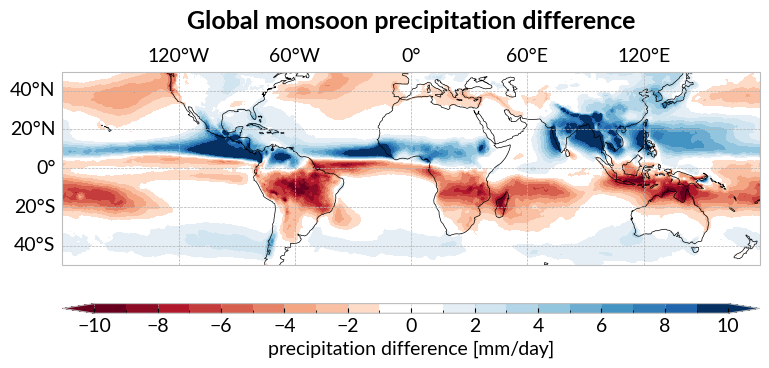

In [11]:
input_data = ds_pr.ds['pr']
pr_jjas = tu.get_month_range_data(input_data, 'Jun', 'Sep')
pr_djfm = tu.get_month_range_data(input_data, 'Dec', 'Mar')

diff_pr = tu.compute_mean(pr_jjas) - tu.compute_mean(pr_djfm)
abs_diff_pr = np.abs(diff_pr)
im_diff = gplt.plot_map(diff_pr,
                        vmin=-10, vmax=10,
                        cmap='RdBu',
                        title=f'Global monsoon precipitation difference',
                        centercolor='white',
                        label='precipitation difference [mm/day]',
                        levels=20,
                        )
savepath = plot_dir +\
    f"/gm_pr_diff.png"
gplt.save_fig(savepath, fig=im['fig'])

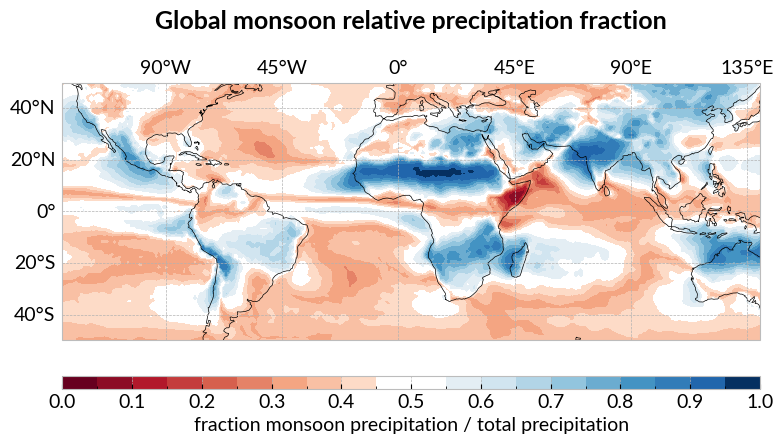

In [12]:
import xarray as xr
reload(tu)
q = 0.6
pr_quantile = tu.compute_quantile(input_data, 0.6)
pr_sum_jjas = tu.compute_sum(pr_jjas)
pr_sum_djfm = tu.compute_sum(pr_djfm)
pr_sum_year = tu.compute_sum(input_data)
rel_frac_jjas = pr_sum_jjas / pr_sum_year
rel_frac_djfm = pr_sum_djfm / pr_sum_year

rel_map = xr.where(
    abs(rel_frac_jjas) > abs(rel_frac_djfm), abs(rel_frac_jjas), rel_frac_djfm
)

im = gplt.plot_map(rel_map,
                   vmin=0, vmax=1,
                   cmap='RdBu',
                   title=f'Global monsoon relative precipitation fraction',
                   centercolor='white',
                   label='fraction monsoon precipitation / total precipitation',
                   levels=20,
                   lon_range=[-130, 140]
                   )

savepath = plot_dir +\
    f"/gm_rel_frac.png"
gplt.save_fig(savepath, fig=im['fig'])

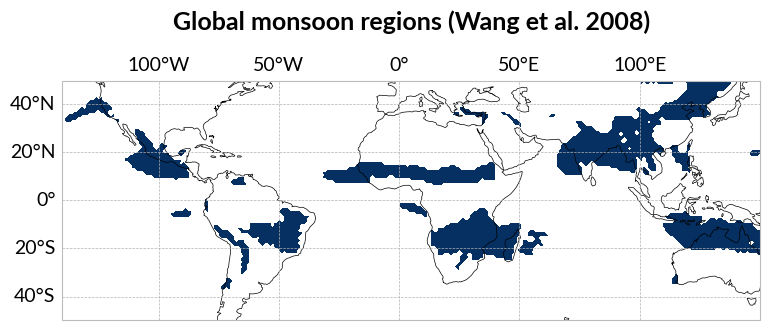

In [13]:
# Global monsoon regions
abs_th = 2
rel_th = 0.6

# Get difference above absolute threshold
diff_map = xr.where(abs(diff_pr) > abs_th, abs(diff_pr), np.nan)
# Get relative difference for 55%
rel_map = xr.where(abs(rel_map) > rel_th, abs(rel_map), np.nan)

# Now combine diff_map and rel_map
m_def = xr.where((rel_map > 0) & (abs(diff_map) > 0), 1, np.nan)
diff_rel_map = xr.where((rel_map > 0) & (abs(diff_map) > 0), diff_map, np.nan)

im = gplt.plot_map(diff_rel_map,
                   vmin=0, vmax=1,
                   cmap='RdBu',
                   title=f'Global monsoon regions (Wang et al. 2008)',
                   centercolor='white',
                   label=None,
                   levels=20,
                   lon_range=[-140, 150]
                   )

savepath = plot_dir +\
    f"/gm_regions.png"
gplt.save_fig(savepath, fig=im['fig'])

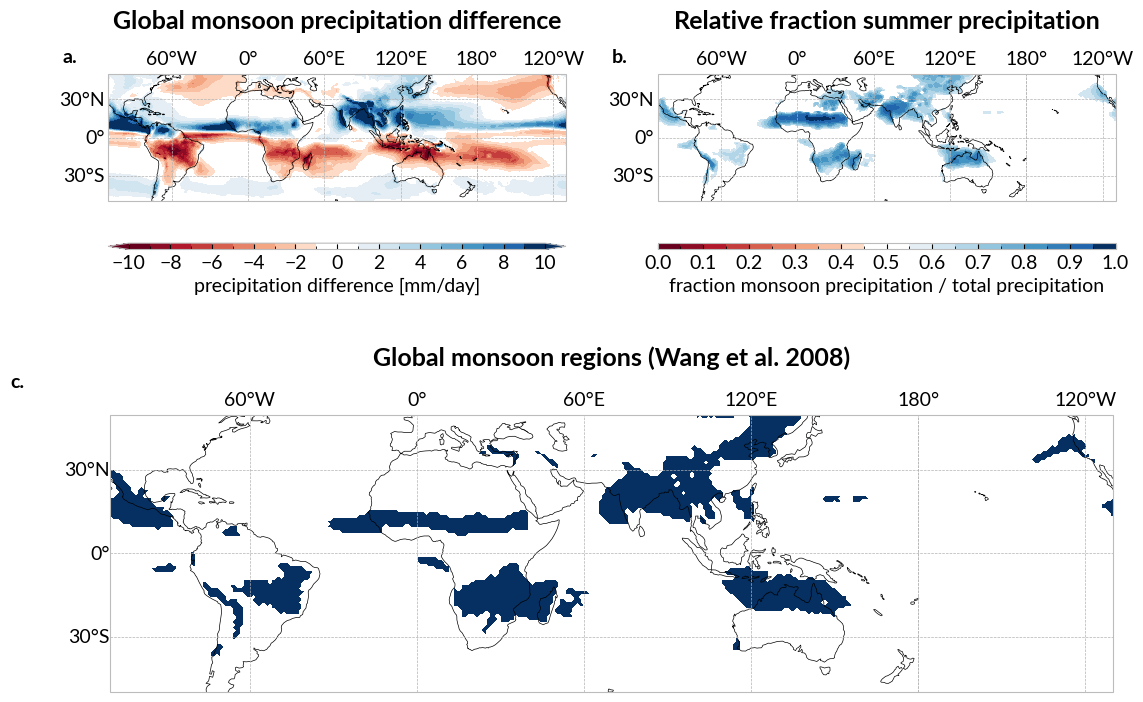

In [14]:
# combine all in one plot
reload(gplt)

im = gplt.create_multi_plot(nrows=2, ncols=2,
                            hspace=0.5,
                            wspace=0.2,
                            full_length_row=True,
                            figsize=(13, 9),
                            projection='PlateCarree',
                            end_idx=3,
                            central_longitude=70,
                            )

map_dict = {
    'diff_map': dict(map=diff_pr, vmin=-10, vmax=10, cmap='RdBu', title='Global monsoon precipitation difference', centercolor='white', label='precipitation difference [mm/day]', levels=20, y_title=1.3),
    'rel_map': dict(map=rel_map, vmin=0, vmax=1, cmap='RdBu', title='Relative fraction summer precipitation', centercolor='white', label='fraction monsoon precipitation / total precipitation', levels=20, y_title=1.3),
    'diff_rel_map': dict(map=diff_rel_map, vmin=0, vmax=1, cmap='RdBu', title='Global monsoon regions (Wang et al. 2008)', centercolor='white', label=None, levels=20, y_title=1.15),
}

for idx, (key, map_dict) in enumerate(map_dict.items()):
    gplt.plot_map(map_dict['map'],
                  vmin=map_dict['vmin'], vmax=map_dict['vmax'],
                  cmap=map_dict['cmap'],
                  title=map_dict['title'],
                  centercolor=map_dict['centercolor'],
                  label=map_dict['label'],
                  levels=map_dict['levels'],
                  lon_range=[-140, 150],
                  ax=im['ax'][idx],
                  y_title=map_dict['y_title'],
                  )

savepath = plot_dir +\
    f"/gm_regions.png"
gplt.save_fig(savepath, fig=im['fig'])